In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [22]:
import os
import pandas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from helper_funcs import *

In [3]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
patients = df['DX_GROUP'].values==1
print(len(df))
df.head(3)

1048


,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,...,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site
460,50642,1,1.0,33.0,1,R,NaN,103.0,98.0,107.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050642,1
464,50646,1,1.0,21.0,1,R,NaN,108.0,100.0,115.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050646,1
465,50647,1,1.0,27.0,1,R,NaN,104.0,97.0,109.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050647,1


In [292]:
avail = [file for file in os.listdir(os.path.join('../Data')) if file.startswith('cmat_latents_')]
avail.sort()
avail

['cmat_latents_CVAE_2021-10-27 11:41:44.052073.pickle',
 'cmat_latents_CVAE_2021-10-28 05:12:17.623449.pickle']

In [294]:
#analysis_name = 'CVAE_2021-10-27 11:41:44.052073'
analysis_name = 'CVAE_2021-10-28 05:12:17.623449'
latent_fn = os.path.join('../Data',f'cmat_latents_{analysis_name}.pickle')
latent_data = pickle.load(open(latent_fn,'rb'))
data = latent_data
print(analysis_name)

CVAE_2021-10-28 05:12:17.623449


In [295]:
keys = list(latent_data.keys())
for key in keys:
    #print(f'{key} {latent_data[key].shape}')
    print(key+f'{latent_data[key].shape}'.rjust(30-len(key)))

cData           (1048, 51, 51)
Z_mu                (1048, 64)
Z_sigma             (1048, 64)
Z                   (1048, 64)
S_mu                (1048, 16)
S_sigma             (1048, 16)
S                   (1048, 16)
z_samples      (100, 1048, 64)
s_samples      (100, 1048, 16)
z_embedding           (514, 2)
s_embedding           (514, 2)
predicted       (1048, 51, 51)
predicted_bg    (1048, 51, 51)


In [296]:
import umap
reducer = umap.UMAP(n_components=2)

umap_bg_all = reducer.fit_transform(data['Z'])
umap_sl_all = reducer.fit_transform(data['S'])

umap_bg_asd = reducer.fit_transform(data['Z'][patients,:])
umap_sl_asd = reducer.fit_transform(data['S'][patients,:])

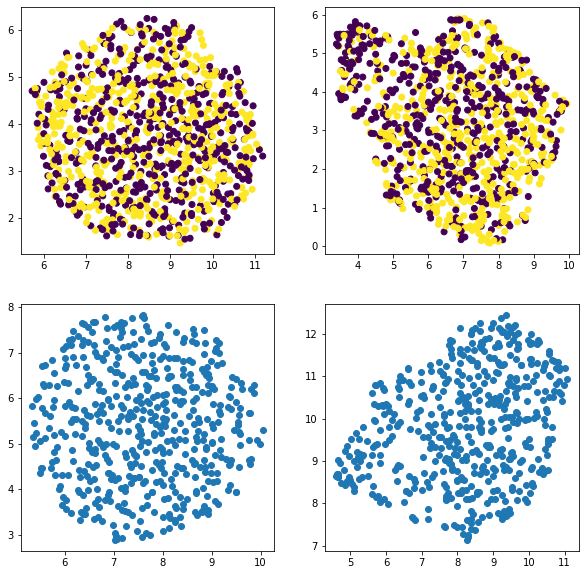

In [297]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(umap_bg_all[:,0],umap_bg_all[:,1],c=df['DX_GROUP'].values)
plt.subplot(2,2,2)
plt.scatter(umap_sl_all[:,0],umap_sl_all[:,1],c=df['DX_GROUP'].values)

plt.subplot(2,2,3)
plt.scatter(umap_bg_asd[:,0],umap_bg_asd[:,1])
plt.subplot(2,2,4)
plt.scatter(umap_sl_asd[:,0],umap_sl_asd[:,1])

In [298]:
import sklearn
from sklearn.mixture import GaussianMixture as GMM

def get_bic(mat,n_components=2):
    gmm = GMM(n_components=n_components,covariance_type='full',tol=0.001,reg_covar=1e-06,max_iter=100,n_init=1,init_params='kmeans',weights_init=None,means_init=None,precisions_init=None,random_state=None,warm_start=False,verbose=0,verbose_interval=10)
    gmm.fit(mat)
    bic = gmm.bic(mat)
    return bic

In [299]:
#ari = np.array([adjusted_rand_score(GMM(n).fit_predict(data['Z'][patients,:]),GMM(20).fit_predict(data['S'][patients,:])) for n in range(2,100)])

In [300]:
bic_z = [get_bic(mat=data['Z'][patients,:],n_components=n_components) for n_components in range(2,101)];print('1/2')
bic_s = [get_bic(mat=data['S'][patients,:],n_components=n_components) for n_components in range(2,101)];print('2/2')

1/2
2/2


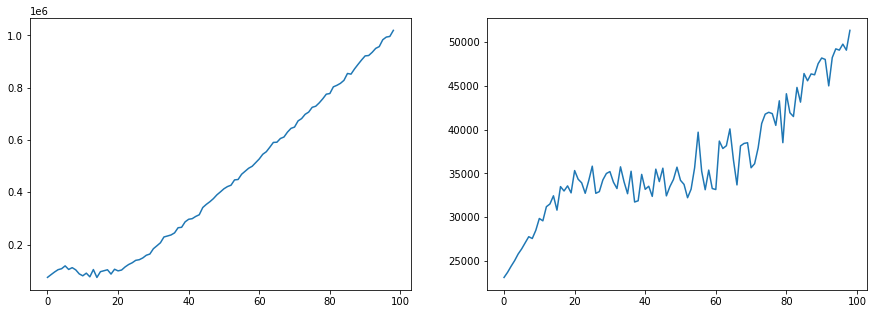

In [301]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(bic_z)
plt.subplot(1,2,2)
plt.plot(bic_s)

In [302]:
rdm_z = make_RDM(data['Z'][patients,:])
rdm_s = make_RDM(data['S'][patients,:])

SL-BG RDM corr 0.3089


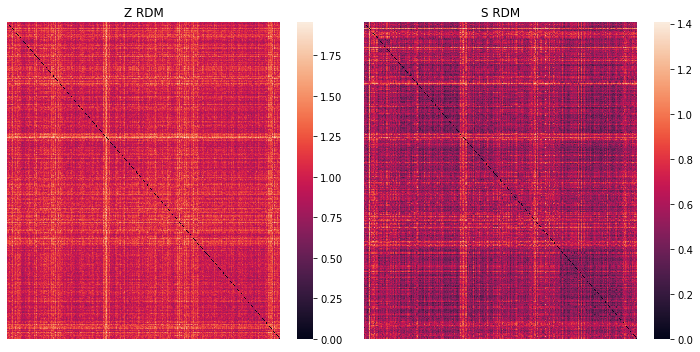

In [303]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(rdm_z,xticklabels=[],yticklabels=[]);plt.title('Z RDM')
plt.subplot(1,2,2)
sns.heatmap(rdm_s,xticklabels=[],yticklabels=[]);plt.title('S RDM')
plt.tight_layout()
print(f'SL-BG RDM corr {np.corrcoef(get_triu(rdm_s),get_triu(rdm_z))[0,1]:.4f}')

In [304]:
rsa1 = [fit_rsa(make_RDM(data['z_samples'][i,:,:]),make_RDM(df['DX_GROUP'].values,data_scale='ordinal')) for i in range(100)]
rsa2 = [fit_rsa(make_RDM(data['s_samples'][i,:,:]),make_RDM(df['DX_GROUP'].values,data_scale='ordinal')) for i in range(100)]

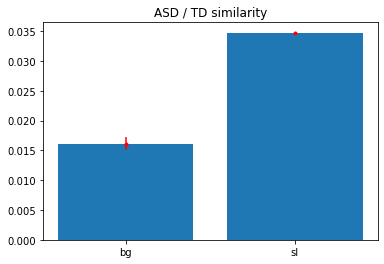

In [305]:
xs = [0,1]
ys = [np.array(rsa1).mean(),np.array(rsa2).mean()]
std = [np.array(rsa1).std(),np.array(rsa2).std()]
plt.bar(xs,ys);
plt.errorbar(xs,ys,std,fmt='r.');
plt.title('ASD / TD similarity');
plt.xticks(xs,labels=['bg','sl']);

In [306]:
sl_bg = np.array([np.corrcoef(get_triu(make_RDM(data['z_samples'][i,:,:])),get_triu(make_RDM(data['s_samples'][i,:,:])))[0,1] for i in range(100)])
sl_bg.mean().round(3)

0.309

In [307]:
# diff = data['cData']-data['predicted']
# diff = abs((data['cData']-data['cData'].mean(axis=0)) - (data['predicted']-data['predicted'].mean(axis=0)))

In [308]:
diff = abs(data['predicted'][patients,:,:]-data['predicted_bg'][patients,:,:])

In [309]:
diffs = np.array([get_triu(diff[i,:,:]) for i in range(diff.shape[0])])
rdm_diff = make_RDM(diffs)

In [310]:
umap_diffs = umap.UMAP(n_components=2).fit_transform(diffs)

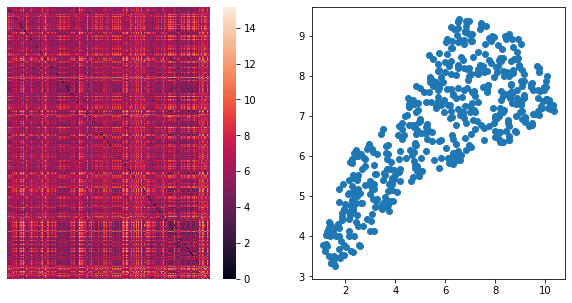

In [311]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(rdm_diff,xticklabels=[],yticklabels=[])
plt.subplot(1,2,2)
plt.scatter(umap_diffs[:,0],umap_diffs[:,1])

In [312]:
%%time
from tqdm import tqdm
bic_d = [get_bic(mat=rdm_diff,n_components=n_components) for n_components in range(2,20)]

CPU times: user 6min 56s, sys: 6min 51s, total: 13min 48s
Wall time: 27.8 s


### RSA

In [317]:
from scipy import stats

In [318]:
def fit_rsa(rdm_data,rdm_model):
    corr = stats.kendalltau
    #r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    r = corr(get_triu(rdm_data),get_triu(rdm_model))[0]
    return r

In [319]:
def key_rsa(key):
    
    if key in ['site','SEX','DSM_IV_TR']:
        data_scale = 'ordinal'
    else:
        data_scale = 'ratio'
    
    subSlice = patients
    vec = df[key].values[subSlice]
    v = ~np.isnan(vec)

    metric_model = 'euclidean'
    rdm_model = make_RDM(vec[v],data_scale=data_scale,metric=metric_model)

    metric_data = 'correlation'
    model_fit_z = np.array([fit_rsa(rdm_model,make_RDM(data['z_samples'][i,subSlice,:],metric=metric_data)[v,:][:,v]) for i in range(10)])
    model_fit_s = np.array([fit_rsa(rdm_model,make_RDM(data['s_samples'][i,subSlice,:],metric=metric_data)[v,:][:,v]) for i in range(10)])


    columns = ['key', 'bg_mean', 'bg_std', 'sl_mean', 'sl_std','n','data_scale','delta']
    res = pd.DataFrame(np.zeros(len(columns))[np.newaxis,:],columns=columns)

    res['key'] = key
    res['bg_mean'] = model_fit_z.mean()
    res['bg_std'] = model_fit_z.std()

    res['sl_mean'] = model_fit_s.mean()
    res['sl_std'] = model_fit_s.std()
    res['n'] = v.sum()
    res['data_scale'] = data_scale
    res['delta'] = model_fit_z.mean() - model_fit_s.mean()
    
    return res

In [320]:
keys = ['site',
 'DSM_IV_TR',
 'AGE_AT_SCAN',
 'SEX',
 'FIQ',
 'VIQ',
 'PIQ',
 'ADOS_TOTAL',
 'ADOS_COMM',
 'ADOS_SOCIAL',
 'ADOS_STEREO_BEHAV',
'ADI_R_SOCIAL_TOTAL_A',
'ADI_R_VERBAL_TOTAL_BV',
'ADI_RRB_TOTAL_C',
 'SRS_RAW_TOTAL',
 'SRS_AWARENESS',
 'SRS_COGNITION',
 'SRS_COMMUNICATION',
 'SRS_MOTIVATION']

res = pd.concat([key_rsa(key) for key in keys])

In [321]:
#res.sort_values(by='bg_mean',ascending=False,inplace=True)
res.head()

,key,bg_mean,bg_std,sl_mean,sl_std,n,data_scale,delta
0,site,0.027870,0.001598,0.072627,0.000154,514,ordinal,-0.044757
0,DSM_IV_TR,0.021022,0.002039,0.006624,0.000330,477,ordinal,0.014398
0,AGE_AT_SCAN,0.026872,0.001355,0.012573,0.000267,514,ratio,0.014298
0,SEX,-0.003353,0.003242,0.012535,0.000462,514,ordinal,-0.015888
0,FIQ,0.008497,0.001521,0.001220,0.000259,481,ratio,0.007277


<ipython-input-322-f671edc37676>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols,i+1)


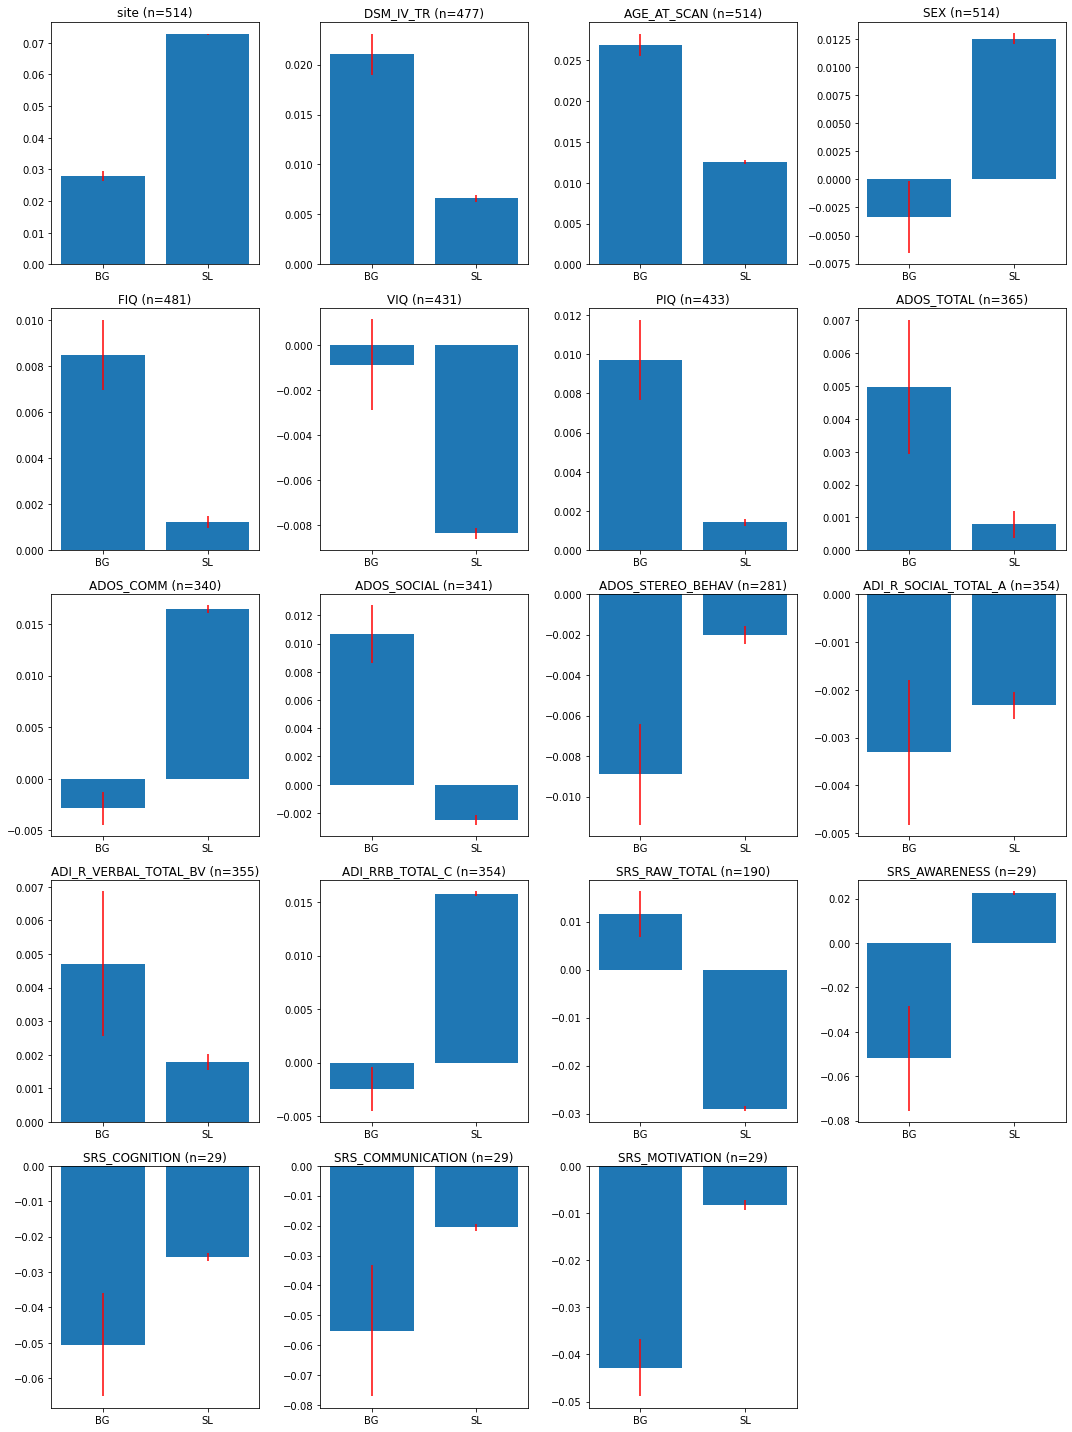

In [322]:
ncols = 4
nrows = np.ceil(len(keys)/ncols)

plt.figure(figsize=(15,4*nrows))
for i in range(len(keys)):
    plt.subplot(nrows,ncols,i+1)
        
    #i = 0
    xs = [0,1]
    ys = [res['bg_mean'].values[i],res['sl_mean'].values[i]]
    se = [res['bg_std'].values[i],res['sl_std'].values[i]]

    plt.bar(xs,ys)
    plt.errorbar(xs,ys,se,fmt='r ')
    plt.xticks(xs,['BG','SL'])
    #plt.title(res['key'].values[i])
    plt.title('{} (n={})'.format(res['key'].values[i],res['n'].values[i]))
    
plt.tight_layout()

In [113]:
df.columns

Index(['participant_id', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',
       'VINELAND_DOMESTIC_V_S